# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [3]:
import io
import os
import numpy as np
import scipy

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [4]:
PATH_TO_DATA = "C:/Users/Chuyi/Documents/DSBA/T2/Deep_Learning/Mini_project_2/nlp_project/data/"

# 1) Monolingual (English) word embeddings 

In [31]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())

        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
        
        index=0
        for i in self.word2id.keys():
            self.word2id[i] = index
            index += 1
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                #self.word2vec[word.lower()] = np.fromstring(vec, sep=' ')
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))


    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        scores = []
        for word_comp in self.word2vec.keys():
            scores.append(self.score(w,word_comp))
        scores_array = np.asarray(scores)

        idxs = scores_array.argsort()[::-1][1:K+1]

        key = list(self.word2vec.keys())
        similar_words = []
        for i in idxs:
            similar_words.append(key[i])
        return similar_words

    def score(self, w1, w2):
        vect1= self.word2vec[w1]
        vect2= self.word2vec[w2]
        dot_product = np.dot(vect1, vect2)
        norm_w1 = np.linalg.norm(vect1)
        norm_w2 = np.linalg.norm(vect2)
        return dot_product/(norm_w1*norm_w2)
    

In [32]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
       
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1),' are the most similar words for: ',w1)

Loaded 200000 pretrained word vectors
cat dog 0.671683666279
dog pet 0.684206402967
dogs cats 0.707438932805
paris france 0.777510854129
germany berlin 0.7420295236
['cats', 'kitty', 'kitten', 'feline', 'kitties']  are the most similar words for:  cat
['dogs', 'puppy', 'Dog', 'doggie', 'canine']  are the most similar words for:  dog
['dog', 'pooches', 'Dogs', 'doggies', 'canines']  are the most similar words for:  dogs
['france', 'Paris', 'parisian', 'london', 'berlin']  are the most similar words for:  paris
['austria', 'europe', 'german', 'berlin', 'poland']  are the most similar words for:  germany


In [33]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v


    def encode(self, sentences, idf=False, fill_blank=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            if idf is False:
                encoding = [w2v.word2vec[w] for w in sent if w in w2v.word2vec]
                if encoding != []:
                    sentemb.append(np.mean(encoding, axis = 0))
                #sentemb.append(np.mean([w2v.word2vec[w] for w in sent if w in w2v.word2vec], axis=0))
                else:
                    sentemb.append([0]*300)
                #assert False, 'TODO: fill in the blank'
                
            else:
                encoding = [w2v.word2vec[w]*idf[w] for w in sent if w in w2v.word2vec and w in idf]
                if encoding != []:
                    sentemb.append(np.mean(encoding, axis = 0))
                else:
                    sentemb.append([0]*300)
                # idf-weighted mean of word vectors
                #sentemb.append(np.mean([w2v.word2vec[w]*idf[w] for w in sent if w in w2v.word2vec and w in idf], axis=0))
                #assert False, 'TODO: fill in the blank'
        
        sentemb_array = np.asarray(sentemb)
        
        return np.vstack(sentemb_array)
        
    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        index_s = sentences.index(s)
        
        #Encode all the sentences and retrieve the vector of the target sentence
        keys = self.encode(sentences, idf)
        query = keys[sentences.index(s),]  
        
        ## normalize embeddings
        keys = keys / np.linalg.norm(keys, 2, 1)[:, None]  # normalize embeddings
        query = query/np.linalg.norm(query)
           
        #compute score with other sentences vector for s            
        scores = np.dot(keys,query) 
        idx = scores.argsort()[::-1][1:K+1]
        
        #select the K  biggest score(corresponding to the K most similar sentences with s)
        sentences_most_similar = []
        scores_most_similar = []
        
        for i in idx:
            sentences_most_similar.append(sentences[i])
            scores_most_similar.append(scores[i])
             
        return  print('The ',K,' most similar sentences for ',s,' are: \n',sentences_most_similar, ',\n With respective similarities: \n',scores_most_similar)



    def score(self, s1, s2, idf=False):
    
        #compute sentemp matrix
        sentemb = self.encode(sentences,idf)
        
        #get back s1 and s2 encoded
        s1_encoded = sentemb[sentences.index(s1)]
        s2_encoded = sentemb[sentences.index(s2)]
        
        #normalization of s1 and s2 before doing dot product
        s1_norm = np.linalg.norm(s1_encoded)
        s2_norm = np.linalg.norm(s2_encoded)
        
        # dot-product of normalized vector = cosine similarity
        s = np.dot(s1_encoded,s2_encoded)/float(s1_norm*s2_norm)
       
        return print('Similarity score between \n',s1,'\n and ',s2,'\n is: ',s,'\n')

    
    def build_idf(self,sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {} 

        for sent in sentences:
                for w in set(sent): #set() gives unique elements in list 
                    idf[w] = idf.get(w, 0) + 1

        for w in idf:
            idf[w] = max(1,(np.log10(len(sentences) / (idf[w]))))
            
        return idf

In [34]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
with open(os.path.join(PATH_TO_DATA, 'sentences.txt')) as f:
    for i, line in enumerate(f):
        sent = line.rstrip().split()
        sentences.append(sent)

# Build idf scores for each word

idf = {}  

# You will be evaluated on the output of the following:
print('\n BoV-mean Model:')
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print('\n')
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13])


idf = s2v.build_idf(sentences)
print('\n BoV-idf Model:')
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print('\n')
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf)

Loaded 200000 pretrained word vectors

 BoV-mean Model:
The  5  most similar sentences for  ['1', 'smiling', 'african', 'american', 'boy', '.']  are: 
 [['an', 'african', 'american', 'man', 'smiling', '.'], ['a', 'little', 'african', 'american', 'boy', 'and', 'girl', 'looking', 'up', '.'], ['an', 'afican', 'american', 'woman', 'standing', 'behind', 'two', 'small', 'african', 'american', 'children', '.'], ['an', 'african', 'american', 'man', 'is', 'sitting', '.'], ['a', 'girl', 'in', 'black', 'hat', 'holding', 'an', 'african', 'american', 'baby', '.']] ,
 With respective similarities: 
 [0.91704533577077552, 0.84985560038758123, 0.82171391395408944, 0.82070473846335068, 0.81911224910118519]


Similarity score between 
 ['1', 'man', 'singing', 'and', '1', 'man', 'playing', 'a', 'saxophone', 'in', 'a', 'concert', '.'] 
 and  ['10', 'people', 'venture', 'out', 'to', 'go', 'crosscountry', 'skiing', '.'] 
 is:  0.572625885972 


 BoV-idf Model:
The  5  most similar sentences for  ['1', 'smil

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [35]:
# 1 - Download and load 50k first vectors of
data_en = "https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec"
data_fr = "https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec"

# TYPE CODE HERE
import urllib.request as url

def load(path, limit = 50000):
    dic = {}
    with url.urlopen(path) as f:
        next(f)
        for i, line in enumerate(f):
            word, vec = line.decode('utf-8').split(' ', 1)
            dic[word] = np.fromstring(vec, sep=' ')
            if i == (limit-1):
                break
    return dic

dict_fr = load(data_fr)
dict_en = load(data_en)


print('dict_fr and dict_en created, with respective length ',len(dict_fr),' and ',len(dict_en))

dict_fr and dict_en created, with respective length  50000  and  50000


In [36]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

def create_matrices(dict_1,dict_2):
    list_X = []
    list_Y = []
    for w in dict_1:
        if w in dict_2:
            list_X.append(dict_1[w])
            list_Y.append(dict_2[w])
    X = np.vstack(list_X)
    Y = np.vstack(list_Y)
    return X,Y

#Call the function to create matrices based en shared words
X, Y = create_matrices(dict_fr,dict_en)

print('2 matrices X and Y were generated: \nX.shape = ',X.shape,'\nY.shape = ',Y.shape)

2 matrices X and Y were generated: 
X.shape =  (18970, 300) 
Y.shape =  (18970, 300)


In [37]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

from scipy.linalg import svd
#from scipy.linalg import orthogonal_procrustes

Xt_Y = np.dot(X.T,Y)
print('Shape of Yt . X: ',Xt_Y.shape) # N*N

print('Singular value decomposition gives: SVD(Yt . X) = U . S . Vt')
U, S, Vt = scipy.linalg.svd(Xt_Y)
print('Shape of U: ',U.shape, ',\nShape of s: ',S.shape, ',\nShape of Vh: ',Vt.shape )

W = np.dot(U,Vt)
print('\nW is generated \nShape of W = U.Vt : ',W.shape)

Shape of Yt . X:  (300, 300)
Singular value decomposition gives: SVD(Yt . X) = U . S . Vt
Shape of U:  (300, 300) ,
Shape of s:  (300,) ,
Shape of Vh:  (300, 300)

W is generated 
Shape of W = U.Vt :  (300, 300)


In [38]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

#Function to compute cos similarity between two vectors, like in exercise 1

def score(vect1, vect2):
    dot_product = np.dot(vect1, vect2.T)
    return dot_product / float(np.linalg.norm(vect1) * np.linalg.norm(vect2))


#Function to find nearest neighbors [K is customisable]

def find_neighbors(target_word, W, original_dict, target_dict, K=5):
    target_vect = original_dict[target_word]
    equiv_word = np.dot(target_vect,W)
    scores = []
    labels = list(target_dict.keys())
    
    for word in labels:
        scores.append(score(equiv_word,target_dict[word]))
    scores_array = np.array(scores)
    idxs = scores_array.argsort()[::-1][1:K+1]

    print('\n Top-%s neighbors of "%s"' % (K, target_word))
    similar_words = []
    for idx in idxs:
        similar_words.append(labels[idx])
    return similar_words
    
print('French to English equivalents:')
for w1 in ['mot', 'voisin', 'proche']:
    print(find_neighbors(w1, W, dict_fr, dict_en, K=5))

print('\n English to French equivalents:')
for w1 in ['word', 'neighbors', 'nearest']:
    print(find_neighbors(w1, W.T, dict_en, dict_fr, K=5))

French to English equivalents:

 Top-5 neighbors of "mot"
['phrase', 'noun', 'meaning', 'words', 'adjective']

 Top-5 neighbors of "voisin"
['neighbor', 'neighbouring', 'neighboring', 'neighbors', 'nearby']

 Top-5 neighbors of "proche"
['closer', 'distant', 'close', 'distantly', 'nearer']

 English to French equivalents:

 Top-5 neighbors of "word"
['substantif', 'signifiant', 'locution', 'mots', 'étymologiquement']

 Top-5 neighbors of "neighbors"
['voisin', 'voisinage', 'peuplades', 'houses', 'our']

 Top-5 neighbors of "nearest"
['distance', 'km', 'kilomètre', 'distant', 'desservie']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [39]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

PATH_TO_SST = "C:/Users/Chuyi/Documents/DSBA/T2/Deep_Learning/Mini_project_2/nlp_project/data/SST/"


#Load the sentences like in the 1st exercise
def load(path, label_cut=False):
    labels = []
    sentences = []
    with open(path, encoding="utf8") as f:
        for line in f:
            
            if label_cut == False:
                label, line = line.split(' ', 1)
                labels.append(label)
                
            sentences.append(line.split())
    return labels, sentences

#Load labeled data
Y_train , X_train = load(os.path.join(PATH_TO_SST,'stsa.fine.train'), label_cut = False)
Y_dev , X_dev = load(os.path.join(PATH_TO_SST,'stsa.fine.dev'), label_cut = False)

#Load non-labeled data
Y_test , X_test = load(os.path.join(PATH_TO_SST,'stsa.fine.test.X'), label_cut = True)


In [40]:
# 2 - Encode sentences with the BoV model above
# TYPE CODE HERE

#First model doesn't need idf weights
idf_3 = {}
W_train = s2v.encode(X_train)
W_dev = s2v.encode(X_dev)
W_test = s2v.encode(X_test)

#Generate idf weights for encoding function
idf_3 = s2v.build_idf(X_train)
W_train_idf = s2v.encode(X_train ,idf_3)
W_dev_idf = s2v.encode(X_dev, idf_3)
W_test_idf = s2v.encode(X_test, idf_3)

In [41]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE
logit = LogisticRegression(penalty = 'l2',C=5)

#Generate Cross validation results on training set with BoV mean model
CV_Scr_mean = cross_val_score(logit,W_train,Y_train,cv=5)

print('BoV-mean model \nCV (=5) results for Simple LogisticRegression \n',CV_Scr_mean)
print('CV results mean = ',np.mean(CV_Scr_mean))

#Test with dev set with BoV mean model
logit.fit(W_train,Y_train)

print('\nCV results on dev sets = ',logit.score(W_dev, Y_dev),'\n')

#Generate Cross validation results on training set with Bov idf model
CV_Scr_idf = cross_val_score(logit,W_train_idf,Y_train,cv=5)

print('BoV-idf model \nCV (=5) results for Simple LogisticRegression \n',CV_Scr_idf)
print('CV results mean = ',np.mean(CV_Scr_idf))

#Test with dev set with BoV idf model
logit.fit(W_train_idf,Y_train)

print('\nCV results on dev sets = ',logit.score(W_dev_idf, Y_dev),'\n')

BoV-mean model 
CV (=5) results for Simple LogisticRegression 
 [ 0.4126242   0.42548217  0.44236396  0.42706503  0.43434936]
CV results mean =  0.42837694153

CV results on dev sets =  0.439600363306 

BoV-idf model 
CV (=5) results for Simple LogisticRegression 
 [ 0.40677966  0.40210403  0.42480983  0.40890451  0.42555686]
CV results mean =  0.413630978608

CV results on dev sets =  0.41961852861 



In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

# turn run_gs to True if you want to run the gridsearch again.
run_gs = True

if run_gs:
    parameter_grid = {
                 'C': [0.001, 0.01, 0.1, 1, 5, 10, 100, 1000]
                 }
    lr = LogisticRegression()
    cross_validation = StratifiedKFold(Y_train, n_folds=5)

    grid_search = GridSearchCV(lr,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation)

    grid_search.fit(W_train, Y_train)
    lr_best_avg = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
else: 
    parameters = {'C': 1.0}
    
    lr_best_avg = LogisticRegression(**parameters)
    lr_best_avg.fit(W_train, Y_train)
    
print(lr_best_avg.score(W_dev,Y_dev))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Best score: 0.438436329588015
Best parameters: {'C': 1}
0.439600363306


In [44]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE

Y_pred_test = logit.predict(W_test)

text_file = open("logreg_bov_y_test_sst.txt", "w")
text_file.write('\n'.join(Y_pred_test))
text_file.close()

In [46]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

# Support Vector Machines

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

# Dev test 

CV_score = cross_val_score(clf,W_train,Y_train,cv=5)
print('BoV-mean model \nCV results for SVM',CV_score)
print('CV mean = ', np.mean(CV_score),'\n')
clf.fit(W_train,Y_train)
print('CV results on dev sets =',clf.score(W_dev, Y_dev),'\n')

CV_score_idf = cross_val_score(clf,W_train_idf,Y_train,cv=5)
print('BoV-idf model \nCV results for SVM',CV_score_idf)
print('CV mean = ', np.mean(CV_score_idf),'\n')
clf.fit(W_train_idf,Y_train)
print('CV results on dev sets =',clf.score(W_dev_idf, Y_dev),'\n')



BoV-mean model 
CV results for SVM [ 0.39158387  0.38281707  0.37097718  0.40187463  0.38335287]
CV mean =  0.386121124168 

CV results on dev sets = 0.405994550409 

BoV-idf model 
CV results for SVM [ 0.37463472  0.38924605  0.36863663  0.39660223  0.34583822]
CV mean =  0.374991569054 

CV results on dev sets = 0.3851044505 



In [47]:
output_file = open("XXX_bov_y_test_sst.txt.txt",'w')
output_file.write('\n'.join(Y_pred))
output_file.close()

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [65]:
import keras

In [72]:
# 1 - Load train/dev/test sets of SST

PATH_TO_SST = "C:/Users/Chuyi/Documents/DSBA/T2/Deep_Learning/Mini_project_2/nlp_project/data/SST/"

#Load the sentences like in the 1st exercise
def load_texts(path, label_cut=False):
    labels = []
    sentences = []
    with open(path, encoding="utf8") as f:
        for line in f:
            if label_cut == False:
                label, line = line.split(' ', 1)
                labels.append(label)
            sentences.append(line.split())
    return labels, sentences

#Load labeled data
Y_train , X_train = load_texts(os.path.join(PATH_TO_SST,'stsa.fine.train'), label_cut = False)
Y_dev , X_dev = load_texts(os.path.join(PATH_TO_SST,'stsa.fine.dev'), label_cut = False)

#Load non-labeled data
Y_test , X_test = load_texts(os.path.join(PATH_TO_SST,'stsa.fine.test.X'), label_cut = True)


from keras.utils import to_categorical
Y_train = to_categorical(Y_train,5)
Y_dev = to_categorical(Y_dev,5)


In [74]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

#from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot

def text_to_integers(text, size):
    output=[]
    for sent in text:
        sent = str(sent)
        new = keras.preprocessing.text.one_hot(sent, 
                                    size,
                                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                     lower=True,
                                     split=" ")
        output.append(new)
    return output

size_voc = 16000
X_train_processed = text_to_integers(X_train, size_voc)
X_dev_processed = text_to_integers(X_dev, size_voc)
X_test_processed = text_to_integers(X_test, size_voc)


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [75]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE

from keras.preprocessing.sequence import pad_sequences

X_train_4 = pad_sequences(X_train_processed)
X_dev_4 = pad_sequences(X_dev_processed)
X_test_4 =pad_sequences(X_test_processed)

print(len(X_train_4[0]))

67


## 4.2 - Design and train your model

In [76]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 2000  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = size_voc  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2))
model.add(Dense(n_classes, activation='softmax'))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.2, recurrent_dropout=0.2)`


In [77]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'rmsprop' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 2000)        32000000  
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                528640    
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 325       
Total params: 32,528,965
Trainable params: 32,528,965
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 64
n_epochs = 4

LSTM = model.fit(X_train_4, Y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_dev_4, Y_dev))

C:\ProgramData\Anaconda3\lib\site-packages\keras\models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 8544 samples, validate on 1101 samples
Epoch 1/4
8544/8544 [==============================] - 166s 19ms/step - loss: 1.4999 - acc: 0.3270 - val_loss: 1.4096 - val_acc: 0.3869
Epoch 2/4
8544/8544 [==============================] - 167s 20ms/step - loss: 1.2058 - acc: 0.4912 - val_loss: 1.4166 - val_acc: 0.4033
Epoch 3/4
8544/8544 [==============================] - 169s 20ms/step - loss: 0.9101 - acc: 0.6440 - val_loss: 1.5879 - val_acc: 0.3706
Epoch 4/4
8544/8544 [==============================] - 170s 20ms/step - loss: 0.6583 - acc: 0.7512 - val_loss: 1.8391 - val_acc: 0.3860


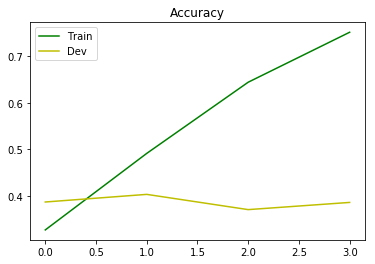

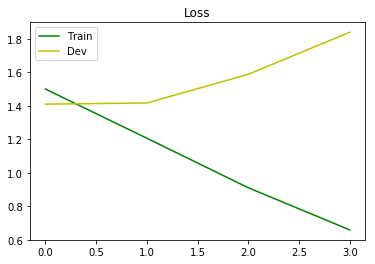

In [79]:
#Plot the evolution of train/dev results w.r.t the number of epochs
from matplotlib import pyplot as plt


plt.title("Accuracy")
plt.plot(LSTM.history["acc"], color="g", label="Train")
plt.plot(LSTM.history["val_acc"], color="y", label="Dev")
plt.legend(loc="best")
plt.show()

plt.title("Loss")
plt.plot(LSTM.history["loss"], color="g", label="Train")
plt.plot(LSTM.history["val_loss"], color="y", label="Dev")
plt.legend(loc="best")
plt.show()

In [81]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

Y_test_pred = model.predict(X_test_4)
Y_pred = []


for i in range(Y_test_pred.shape[0]):
    index_max = list(Y_test_pred[i]).index(max(Y_test_pred[i]))
    Y_pred.append(str(index_max))
Y_pred = np.asarray(Y_pred)

#create file with predictions
output_file = open("logreg_lstm_y_test_sst.txt.txt",'w')
output_file.write('\n'.join(Y_pred))
output_file.close()

#print(Y_test_pred[2])

## 4.3 -- innovate !

In [26]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 2000  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = size_voc  # size of the vocabulary
n_classes  = 5

model2 = Sequential()

model2.add(Embedding(vocab_size, embed_dim))

model2.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2))

model2.add(Dense(n_classes, activation='softmax'))


loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'Adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model2.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model2.summary())

bs = 64
n_epochs = 4

LSTM = model2.fit(X_train_4, Y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_dev_4, Y_dev))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.2, recurrent_dropout=0.2)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 2000)        4000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                528640    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 4,528,965
Trainable params: 4,528,965
Non-trainable params: 0
_________________________________________________________________
None


C:\ProgramData\Anaconda3\lib\site-packages\keras\models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 8544 samples, validate on 1101 samples
Epoch 1/4
8544/8544 [==============================] - 137s 16ms/step - loss: 1.5306 - acc: 0.3141 - val_loss: 1.4655 - val_acc: 0.3524
Epoch 2/4
8544/8544 [==============================] - 122s 14ms/step - loss: 1.3283 - acc: 0.4341 - val_loss: 1.4871 - val_acc: 0.3488
Epoch 3/4
8544/8544 [==============================] - 120s 14ms/step - loss: 1.1556 - acc: 0.5302 - val_loss: 1.5657 - val_acc: 0.3433
Epoch 4/4
8544/8544 [==============================] - 120s 14ms/step - loss: 0.9859 - acc: 0.6040 - val_loss: 1.7428 - val_acc: 0.3261


In [27]:
output_file = open("XXX_XXX_y_test_sst.txt.txt",'w')
output_file.write('\n'.join(Y_pred))
output_file.close()